## Исследовательский проект: Анализ оттока клиентов банка "Метанпром"

In [ ]:
# загрузим необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
plt.style.use('ggplot')
import numpy as np
from scipy import stats as st
from math import factorial
sns.set(font_scale=1.3)

### Шаг 1. Загрузка данных, первичное знакомство с данными и предобработка

1. Загрузка данных
2. Проверка соответсвия типов данных
3. Наименование колонок
4. Наличие дубликатов
5. Проверка и заполнение (при необходимости) пропусков в данных

In [ ]:
data = pd.read_csv('bank_dataset.csv')
data.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
City                10000 non-null object
Gender              10000 non-null object
Age                 10000 non-null int64
Objects             10000 non-null int64
Balance             6383 non-null float64
Products            10000 non-null int64
CreditCard          10000 non-null int64
Loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
Churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


Для исследования нам предоставлены данные таблицы из 10 тысяч строк, где для каждого из клиентов банка указанего id и информация об 11 признаках.

Приведем названия столбцов к нижнему регистру и заменим некоторые из названий на более удобные и короткие.

In [ ]:
data.columns

Index(['userid', 'score', 'City', 'Gender', 'Age', 'Objects', 'Balance',
       'Products', 'CreditCard', 'Loyalty', 'estimated_salary', 'Churn'],
      dtype='object')

In [ ]:
data.columns = data.columns.str.lower()
data = data.rename(columns = {'userid': 'id', 'creditcard': 'credit_card', 'estimated_salary': 'salary'})

In [ ]:
data.columns

Index(['id', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'credit_card', 'loyalty', 'salary', 'churn'],
      dtype='object')

Проверим наличие дубликатов

In [ ]:
data.duplicated().sum()

0

Посмотрим, есть ли в данных пропуски

In [ ]:
data.isnull().sum()

id                0
score             0
city              0
gender            0
age               0
objects           0
balance        3617
products          0
credit_card       0
loyalty           0
salary            0
churn             0
dtype: int64

В столбце с балансом 3617 пропусков. 36% данных по балансу клиентов отсутсвует. Чтобы сделать предположение о причинах этих пропусков, посмотрим на данные других значений у пользователей с отсутствующим балансом

In [ ]:
nan_balance = data[data['balance'].isnull()]

In [ ]:
nan_balance['products'].value_counts()

2    2600
1     905
3      98
4      14
Name: products, dtype: int64

Наибольшая часть пользуется 1-2 продуктами банка

In [ ]:
nan_balance['churn'].value_counts()

0    3117
1     500
Name: churn, dtype: int64

In [ ]:
nan_balance['credit_card'].value_counts()

1    2592
0    1025
Name: credit_card, dtype: int64

Большая часть пропусков - это клиенты, которые не ушли в отток и продолжают пользоваться услугами банка, у большинства имеется кредитная карта.

Проанализировав данные, можем сделать вывод, что пропуски в данных вряд ли соответствуют нулевому балансу на счете. Скорее всего это техническая ошибка. Больше половины имеют кредитную карту. Вероятно, клиенты пользуются теми услугами банка, которые не предполагают открытие счета. И просто напросто его не имеют. Возможно, что этот столбец отражает лишь счет на дебетовой карте, которая может быть не у всех пользователй банка. Следовательно заполнять пропуски мы не будем, оставим как есть во избежании искажения выводов.

### Шаг 2. Проведение исследовательского анализа данных (EDA)

1. Изучение и анализ средних значений и стандартных отклонений признаков 
2. Изучение распределений признаков 
3. Выделение аномалий
4. Корреляционный анализ

In [ ]:
data.head()

,id,score,city,gender,age,objects,balance,products,credit_card,loyalty,salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


Посмотрим на описание статистических данных таблицы

In [ ]:
data.drop(['id'], axis=True).describe()

,score,age,objects,balance,products,credit_card,loyalty,salary,churn
count,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


По статистическим данным можем сделать следующие выводы:
* Максимальный возраст клиентов банка - 92 года, минимальный - 18
* 20% пользователей ушли в отток
* максимальная заработная плата клиентов - 199 тысяч, минимальная - 11 руб (что, конечно, странно и скорее всего либо это техническая ошибка, либо клиент не имеет официального дохода и сам указал такую сумму)

Посмотрим, какое количество клиентов зарабатывает меньше 10 тысяч

In [ ]:
len(data[data['salary'] < 10000]) / len(data) * 100

5.08

Проведем анализ признаков

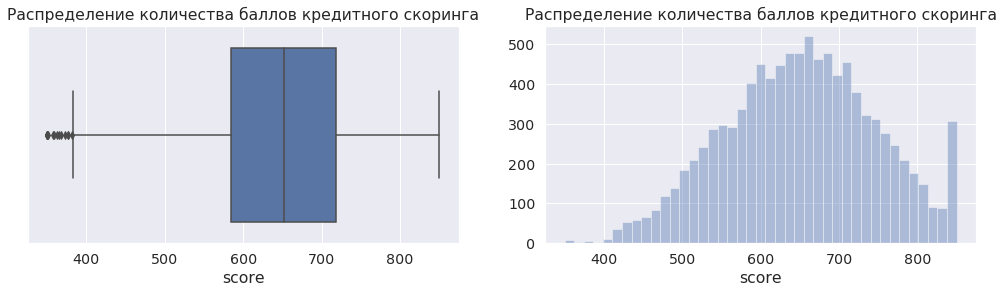

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (17, 4))
sns.boxplot(data['score'], ax = axes[0])
axes[0].set_title('Распределение количества баллов кредитного скоринга')
sns.distplot(data['score'], ax = axes[1], kde = False)
axes[1].set_title('Распределение количества баллов кредитного скоринга')
plt.show()
 

* Вцелом для кредитного скоринга характерно нормальное распределение с характерным выбросом высоких значений. Среднее значение баллов составляет примерно 650

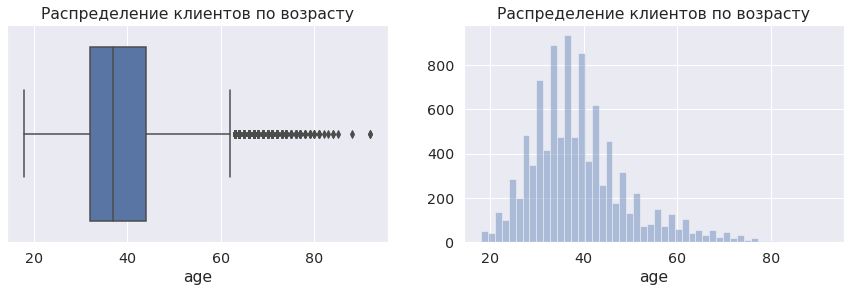

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.boxplot(data['age'], ax = axes[0])
axes[0].set_title('Распределение клиентов по возрасту')
sns.distplot(data['age'], ax = axes[1], kde = False)
axes[1].set_title('Распределение клиентов по возрасту')
plt.show()

In [ ]:
len(data[data['age'] > 60]) / len(data) * 100

4.64

* Основную часть клиентов банка составляют люди от 18 до 60 лет. Менее 5% составляют клиенты от 60 лет и старше. 

Добавим в наши данные столбец, в котором всех пользователей разделим на возрастные категории.

In [ ]:
def ages(age):
    if age <= 24:
        return 'до 25'
    elif age <= 34:
        return 'от 25 до 35'
    elif age <= 44:
        return 'от 35 до 45'
    elif age <= 54:
        return 'от 45 до 55'
    elif age <= 62:
        return 'от 55 до 65'
    return 'более 65'

data['age_group'] = data['age'].apply(ages)

In [ ]:
age_group = data.groupby(['age_group'])['id'].agg('count').sort_values().reset_index()
age_group

,age_group,id
0,более 65,359
1,до 25,457
2,от 55 до 65,523
3,от 45 до 55,1458
4,от 25 до 35,3222
5,от 35 до 45,3981


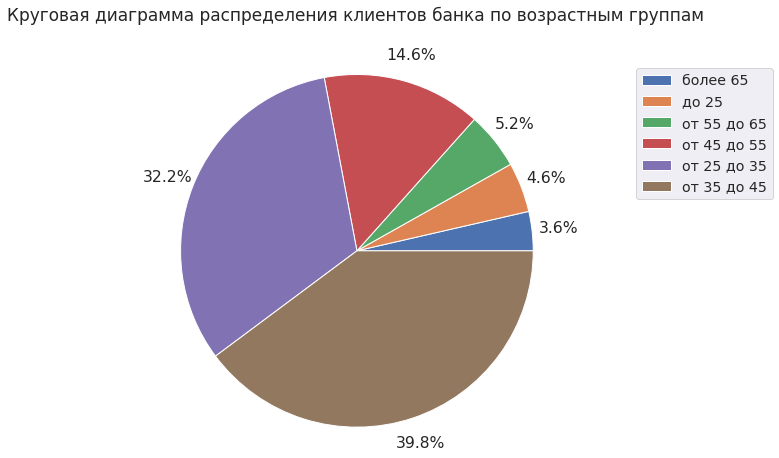

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
ax.pie(age_group['id'], autopct='%1.1f%%', pctdistance=1.15)
plt.legend(age_group['age_group'], bbox_to_anchor=(1.2,1))
plt.title('Круговая диаграмма распределения клиентов банка по возрастным группам', fontsize=17, pad=40)
ax.axis('equal')
plt.show()

* Более 70% составляют клиенты от 25 до 45 лет.

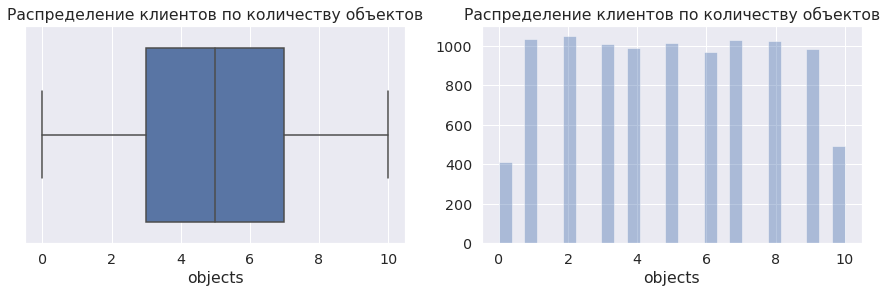

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.boxplot(data['objects'], ax = axes[0])
axes[0].set_title('Распределение клиентов по количеству объектов')
sns.distplot(data['objects'], ax = axes[1], kde = False)
axes[1].set_title('Распределение клиентов по количеству объектов')
plt.show()

* Клиенты банка имеют в собственности от 0 до 10 объектов. Вцелом количество объектов распределно между клиентами примерно одинаково. Чуть меньше клиентов имеет 10 объектов или не имеет вовсе.

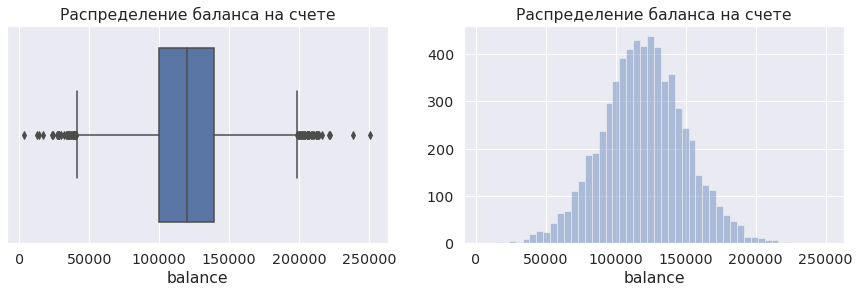

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.boxplot(data['balance'].dropna(), ax = axes[0])
axes[0].set_title('Распределение баланса на счете')
sns.distplot(data['balance'].dropna(), ax = axes[1], kde = False)
axes[1].set_title('Распределение баланса на счете')
plt.show()

* Распределение нормальное. В среднем у клиентов банка на счете хранится около 120 тысяч. У большинства от 50 до 200 тысяч.

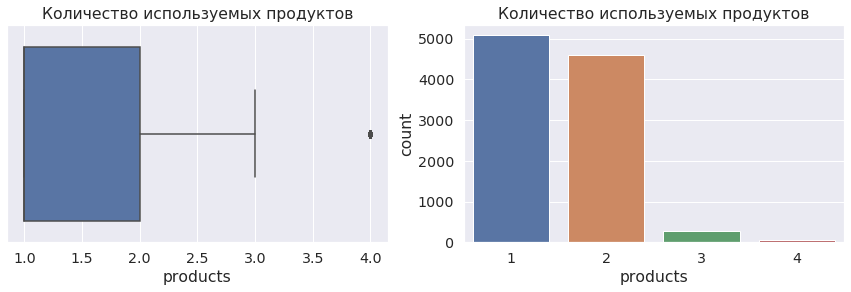

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.boxplot(data['products'], ax = axes[0])
axes[0].set_title('Количество используемых продуктов')
sns.countplot(data['products'], ax = axes[1])
axes[1].set_title('Количество используемых продуктов')
plt.show()

In [ ]:
len(data[data['products'] > 2]) / len(data) * 100

3.26

* Большинство клиентов пользуется 1-2 продуктами банка. Всего 3% пользуется 3-4 продуктами.

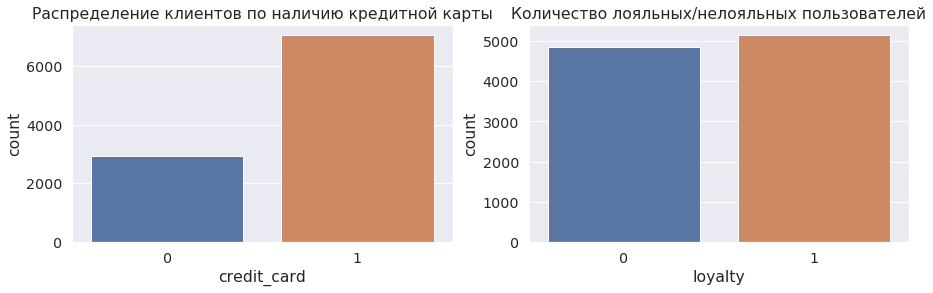

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.countplot(data['credit_card'], ax=axes[0])
axes[0].set_title('Распределение клиентов по наличию кредитной карты')
sns.countplot(data['loyalty'], ax=axes[1])
axes[1].set_title('Количество лояльных/нелояльных пользователей')
plt.show()

* Около 70% клиентов имеют кредитную карту. Количество лояльных и нелояльных пользователей распределено примерно поровну

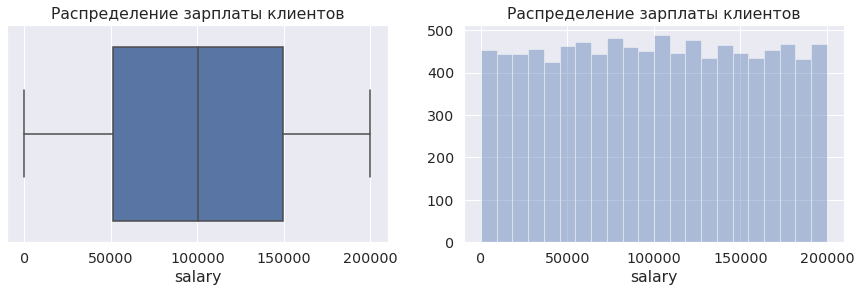

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.boxplot(data['salary'], ax = axes[0])
axes[0].set_title('Распределение зарплаты клиентов')
sns.distplot(data['salary'], ax = axes[1], kde = False)
axes[1].set_title('Распределение зарплаты клиентов')
plt.show()

Средняя зарплата клиентов банка 100 тысяч.

In [ ]:
len(data[data['salary'] < 10000]) / len(data) * 100

5.08

* 5% клиентов зарабатывают меньше 10 тысяч.

In [ ]:
print('Количество клиентов банка "Метанпром" в городе:')
print('Ярославль:', len(data[data['city'] == 'Ярославль']))
print('Ростов Великий:', len(data[data['city'] == 'Ростов Великий']))
print('Рыбинск:', len(data[data['city'] == 'Рыбинск']))

Количество клиентов банка "Метанпром" в городе:
Ярославль: 5014
Ростов Великий: 2509
Рыбинск: 2477


* Половина клиентов банка проживает в Ярославле. Остальная половина поделена поровну между Ростовом Великим и Рыбинском

In [ ]:
print('Количество клиентов мужского пола:', len(data[data['gender'] == 'М']))
print('Количество клиентов женского пола:', len(data[data['gender'] == 'Ж']))

Количество клиентов мужского пола: 5457
Количество клиентов женского пола: 4543


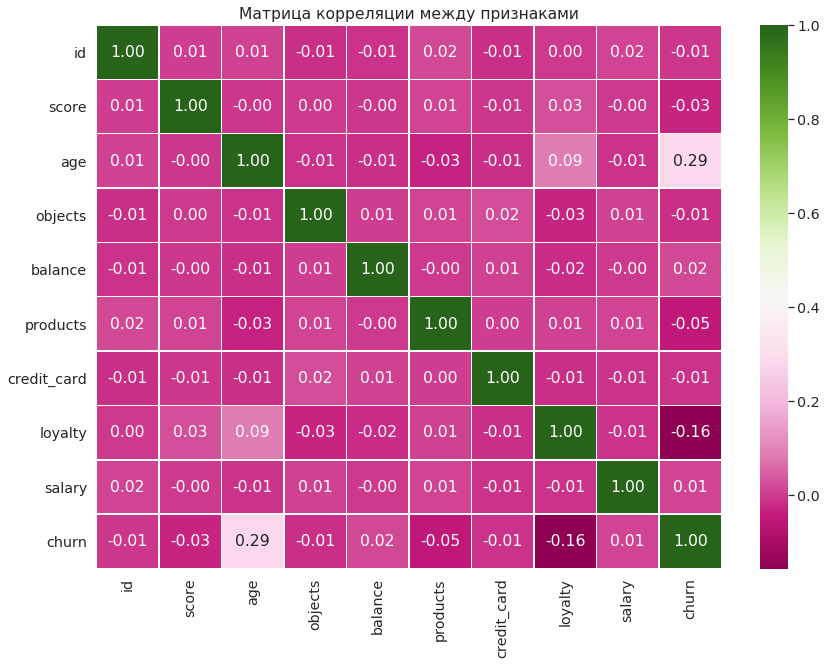

In [ ]:
cm = data.corr()
plt.figure(figsize = (14,10))
sns.heatmap(cm, annot=True, fmt = '0.2f', linewidths = .5, cmap='PiYG')
plt.title('Матрица корреляции между признаками')
plt.show()

Построив матрицу корреляций, видим, что сильной связи между признаками особо нет. Более менее связаны между собой возраст и отток (имеют наибольшую долю корреляции).

Проведя исследовательский анализ данных, сделали следующие выводы:
* Основную часть клиентов банка составляют люди от 18 до 60 лет. Менее 5% составляют клиенты от 60 лет и старше. Максимальный возрастов клиентов - 92 года. Средний возраст клиентов - 38 лет.
* Баллы кредитного скоринга от 350 до 850. Среднее значение - 650 баллов.
* В среднем 5 объектов в собственности (от 0 до 10)
* На счете в срелнем 120 тысяч
* Большинство пользуется 1-2 продуктами банка. 3% пользуется 3-4.
* Половина клиентов лояльны
* 70% имеют кредитную карту
* Средняя зарплата 100 тысяч 
* 50% клиентов из Ярославля, по 25% из Ростова и Рыбинска.

### Шаг 3. Составление портрета клиентов, склонных уходить в отток

1. Анализ распределения признаков для двух сегментов клиентов (тех, кто остался и тех, кто ушел в отток)
2. Описание портрета клиента, склонного к оттоку

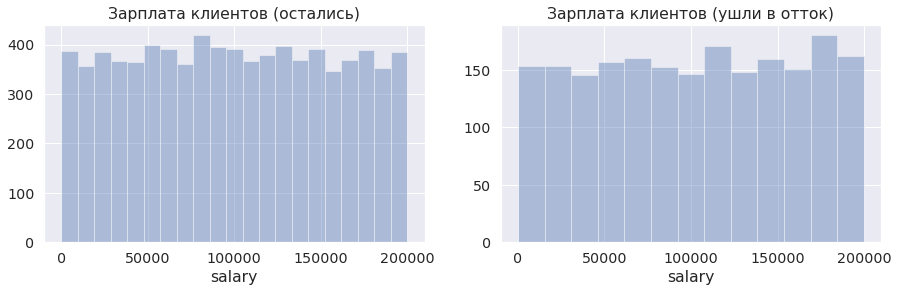

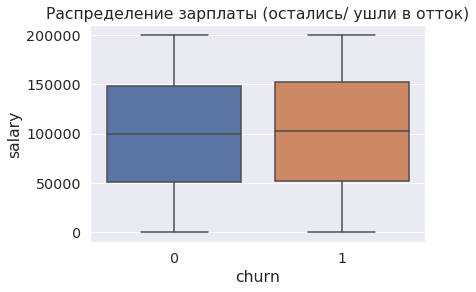

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.distplot(data[data['churn'] == 0]['salary'], ax = axes[0], kde = False)
axes[0].set_title('Зарплата клиентов (остались)')
sns.distplot(data[data['churn'] == 1]['salary'], ax = axes[1], kde = False)
axes[1].set_title('Зарплата клиентов (ушли в отток)')
plt.show()
sns.boxplot(x=data['churn'], y=data['salary'])
plt.title('Распределение зарплаты (остались/ ушли в отток)')
plt.show()

* Разницы в распределении зарплаты между клиентами, которые ушли в оток и клиентами, которые остались, вцелом нет. Средняя зарплата у обеих категорий окло 100 тысяч.

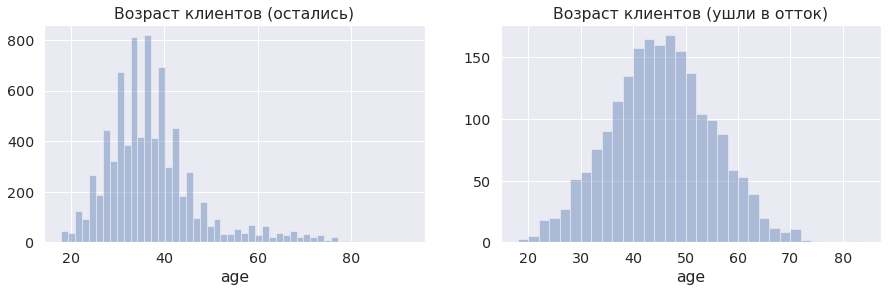

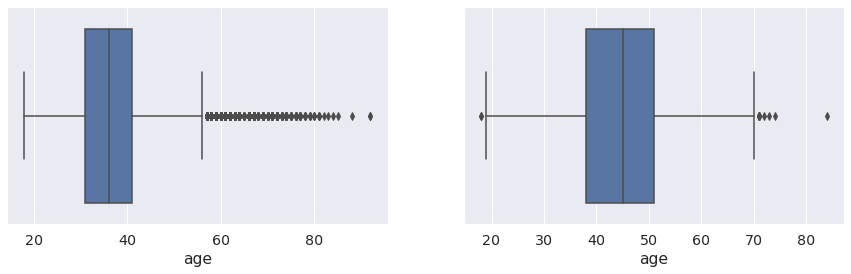

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.distplot(data[data['churn'] == 0]['age'], ax = axes[0], kde = False)
axes[0].set_title('Возраст клиентов (остались)')
sns.distplot(data[data['churn'] == 1]['age'], ax = axes[1], kde = False)
axes[1].set_title('Возраст клиентов (ушли в отток)')
plt.show()

fig, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.boxplot(data[data['churn'] == 0]['age'], ax = axes[0])
#axes[0].set_title('Распределение по возрасту клиентов не ушедших в отток')
sns.boxplot(data[data['churn'] == 1]['age'], ax = axes[1])
#axes[1].set_title('Распределение по возрасту клиентов ушедших в отток')
plt.show()

In [ ]:
print('Средний возраст клиентов, которые остались:', data[data['churn'] == 0]['age'].mean())
print('Средний возраст клиентов, ушедших в отток:', data[data['churn'] == 1]['age'].mean())

Средний возраст клиентов, которые остались: 37.40838879819164
Средний возраст клиентов, ушедших в отток: 44.8379970544919


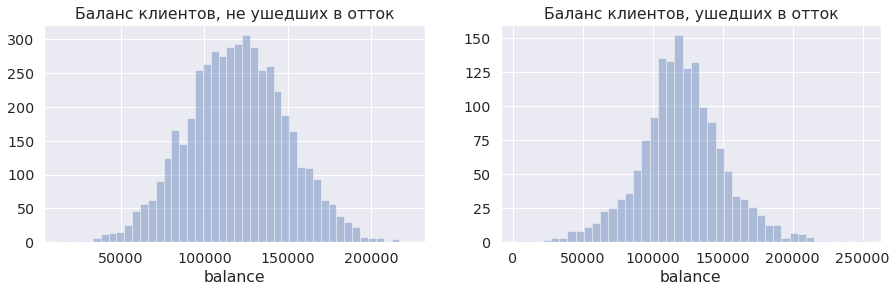

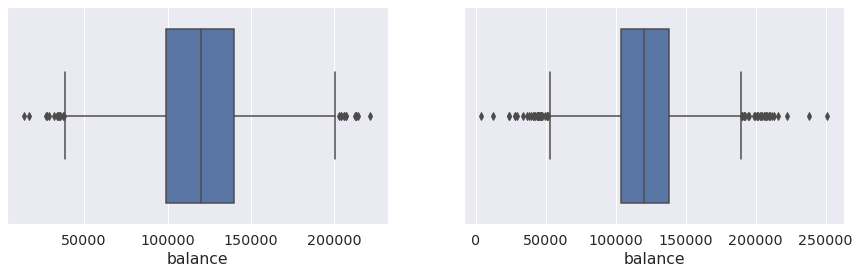

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.distplot(data.dropna().query('churn == 0')['balance'], ax = axes[0], kde = False)
axes[0].set_title('Баланс клиентов, не ушедших в отток')
sns.distplot(data.dropna().query('churn == 1')['balance'], ax = axes[1], kde = False)
axes[1].set_title('Баланс клиентов, ушедших в отток')
plt.show()

fig, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.boxplot(data.dropna().query('churn == 0')['balance'], ax = axes[0])
#axes[0].set_title('Распределение по возрасту клиентов не ушедших в отток')
sns.boxplot(data.dropna().query('churn == 1')['balance'], ax = axes[1])
#axes[1].set_title('Распределение по возрасту клиентов ушедших в отток')
plt.show()

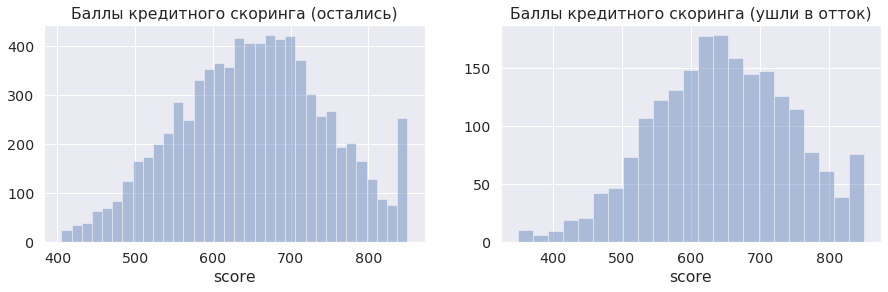

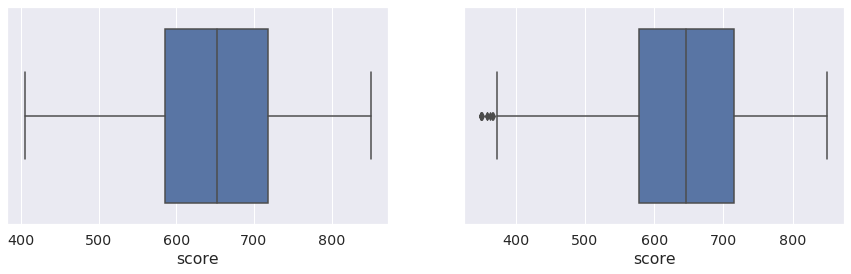

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.distplot(data[data['churn'] == 0]['score'], ax = axes[0], kde = False)
axes[0].set_title('Баллы кредитного скоринга (остались)')
sns.distplot(data[data['churn'] == 1]['score'], ax = axes[1], kde = False)
axes[1].set_title('Баллы кредитного скоринга (ушли в отток)')
plt.show()

fig, axes = plt.subplots(1, 2, figsize = (15, 4))
sns.boxplot(data[data['churn'] == 0]['score'], ax = axes[0])
#axes[0].set_title('Распределение по возрасту клиентов не ушедших в отток')
sns.boxplot(data[data['churn'] == 1]['score'], ax = axes[1])
#axes[1].set_title('Распределение по возрасту клиентов ушедших в отток')
plt.show()

Средний балл кредитного скоринга у обеих групп (ушедших в отток и оставшихся) 650 баллов.

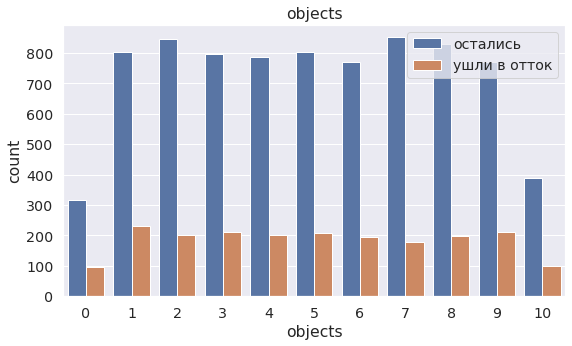

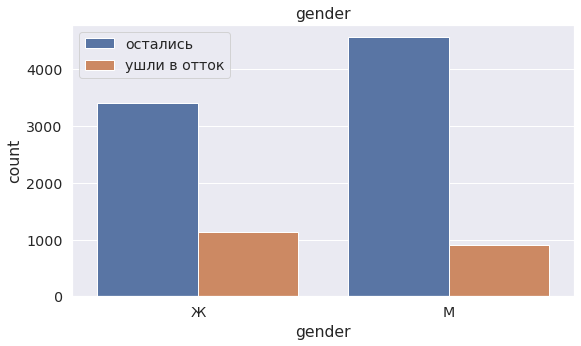

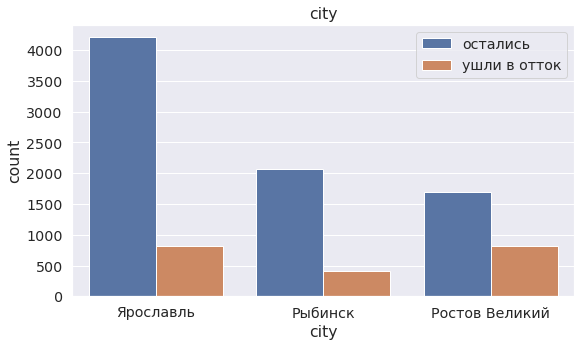

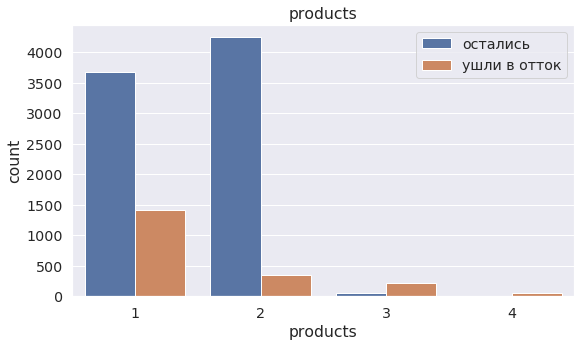

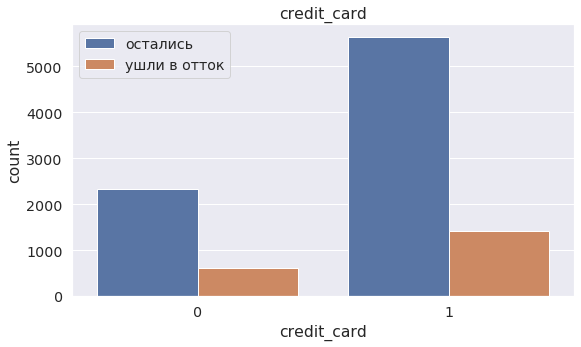

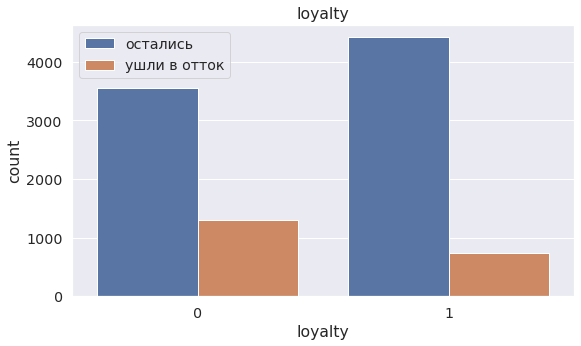

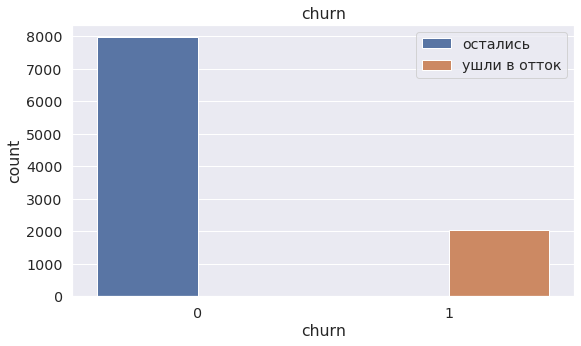

In [ ]:
for column in ['objects', 'gender', 'city', 'products', 'credit_card', 'loyalty', 'churn']:
    plt.figure(figsize=(9,5))
    sns.countplot(x=data[column], hue='churn', data=data)
    plt.title(column)
    plt.legend(['остались', 'ушли в отток'])
    plt.show()

In [ ]:
mean_data = data.drop('id', axis=True).groupby('churn').agg('mean').reset_index()
mean_data

,churn,score,age,objects,balance,products,credit_card,loyalty,salary
0,0,651.853196,37.408389,5.033279,119535.864270,1.544267,0.707146,0.554565,99738.391772
1,1,645.351497,44.837997,4.932744,120746.971132,1.475209,0.699067,0.360825,101465.677531


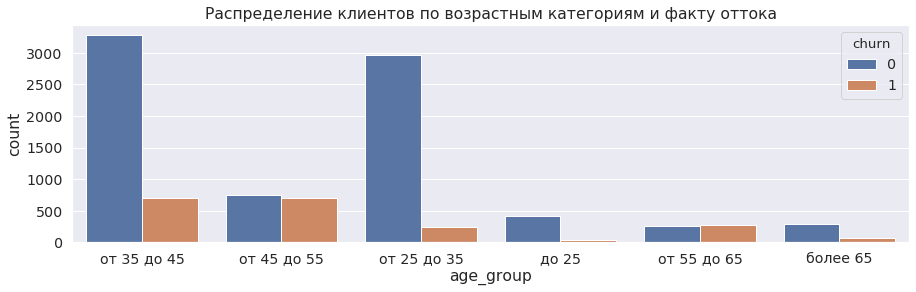

In [ ]:
plt.figure(figsize = (15, 4))
sns.countplot(x = data['age_group'], hue = 'churn', data=data)
plt.title('Распределение клиентов по возрастным категориям и факту оттока')
plt.show()

* Половина клиентов из Ростова Великого ушла в отток. Примерно такое количество клиентов (около 800) из Ярославля тоже ушли в отток. Меньшая часть ушедших в отток клиентов из Рыбинска (около 500)
* Почти все клиенты, которые пользуются 3 или 4 продуктами уходят в отток. Из тех, кто пользуется 1 продуктом (примерно 30%) уходят в отток. 
* Наибольшая доля тех, кто уходит в отток имеют кредитную карту. Но из неушедших в отток также большая часть пользуется кредитной картой
* Среди лояльных клиентов меньше доля оттока
* Наибольшая доля оттока среди возрастной категории 45-55 лет и 55-65 лет (почти 50%)

### Портрет клиента, уходящего в отток

В ходе проанализированного распределения признаков, можем составить портрет клиента, наиболее склонного к оттоку (описание ниже  не характерно для всех клиентов, уходящих в отток, но отражает наибольшую долю среди исследуемых признаков)

* клиент в возрасте 40-60 лет, наибольшая доля среди женщин
* чаще из Ростова Великого или Ярославля, реже из Рыбинска
* не лоялен к банку
* пользуется 3 и более банковскими продуктами


### Шаг 4. Проверка статистических гипотез

1. Составление и проверка гипотезы о различии доходов между теми, кто уходит в отток и теми, кто остается
2. При необходимости проверка других гипотез

In [ ]:
data_churn = pd.DataFrame(data.query('churn == 1'))
data_no_churn = pd.DataFrame(data.query('churn == 0'))

In [ ]:
churn = np.array(data_churn['salary'])
no_churn = np.array(data_no_churn['salary'])

In [ ]:
print('Дисперсия доходов клиентов, не ушедших в отток:', np.var(no_churn))
print('Дисперсия доходов клиетов, ушедших в отток:', np.var(churn))

Дисперсия доходов клиентов, не ушедших в отток: 3294987575.73531
Дисперсия доходов клиетов, ушедших в отток: 3352201702.316679


In [ ]:
print('Средняя зарплата клиентов, не ушедших в отток:', np.mean(no_churn))
print('Средняя зарплата клиентов, ушедших в отток:', np.mean(churn))

Средняя зарплата клиентов, не ушедших в отток: 99738.39177194524
Средняя зарплата клиентов, ушедших в отток: 101465.67753068237


Проведем статистический тест и узнаем различаются ли доходы клиентов, которые ушли в отток и которые остались. Сформулируем нулевую и альтернативную гипотезы.

#### Нулевая гипотеза (Н0): Различий в доходах между теми, кто ушел в отток и теми, кто остался нет или эти различия незначительны.
#### Альтернативная гипотеза(H1): Различия между доходами двух групп пользователей есть и они имеют статистическую значимость.

Прежде чем приступать к проведению статистического теста, посмотрим на распределение признака и количество наблюдений
  

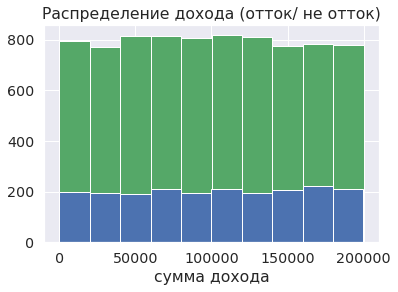

In [ ]:
plt.hist(no_churn, color = 'g')
plt.hist(churn, color = 'b')
plt.title('Распределение дохода (отток/ не отток)')
plt.xlabel('сумма дохода')
plt.show()

In [ ]:
from scipy.stats import shapiro

data1 = churn
stat, p = shapiro(data1)
alpha= 0.05
print('p-значение', p)
if p > alpha:
    print('Данные распределены нормально')
else:
    print('Данные не имеют нормального распределения')

p-значение 4.594104044877579e-25
Данные не имеют нормального распределения


И график, и критерий Шапиро-Уилка подтверждают ненормальность распределения.
   

In [ ]:
print('Количество наблюдений в группе оттока:', len(churn))
print('Количество наблюдений в группе тех, кто остался:', len(no_churn))

Количество наблюдений в группе оттока: 2037
Количество наблюдений в группе тех, кто остался: 7963


In [ ]:
alpha = .05
results = st.ttest_ind(churn, no_churn)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.22644042802223346
Не получилось отвергнуть нулевую гипотезу


In [ ]:
results_m = st.mannwhitneyu(churn, no_churn)
print('p-значение:', results_m.pvalue)
if results_m.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11352575465076892
Не получилось отвергнуть нулевую гипотезу


Критерий Манна-Уитни также показал отсутствие статистической значимости в различиях доходов клиентов.
   

Тест показал, что различия между ушедшими и оставшимися пользователями не имеют статистическую значимость, следовательно принимаем нулевую гипотезу о равенстве доходов пользователей.

Также проведем статистические тесты для возраста и количества продуктов, так как именно эти признаки при изучении их в предыдущем шаге показали наиболее значительные различия в группах оттока и не оттока.
   

Проведем статистический тест и сравним возраст клиентов, ушедших в отток и оставшихся.
#### Нулевая гипотеза (Н0): Возраст тех клиентов, которые ушли в отток и тех, которые остались не различается.
#### Альтернативная гипотеза (Н1): Различие в возрасте клиентов ушедших в отток и оставшихся имеет статистическую значимость.

In [ ]:
age_churn = np.array(data_churn['age'])
age_no_churn = np.array(data_no_churn['age'])

In [ ]:
np.var(age_no_churn)

102.51009916216009

In [ ]:
np.var(age_churn)

95.24130536474341

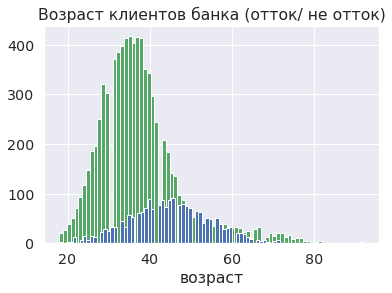

In [ ]:
plt.hist(age_no_churn, color = 'g', bins=80)
plt.hist(age_churn, color = 'b', bins=80)
plt.title('Возраст клиентов банка (отток/ не отток)')
plt.xlabel('возраст')
plt.show()

In [ ]:
data2 = age_churn
stat, p = shapiro(data2)
alpha= 0.05
print('p-значение', p)
if p > alpha:
    print('Данные распределены нормально')
else:
    print('Данные не имеют нормального распределения')

p-значение 0.005956501234322786
Данные не имеют нормального распределения


In [ ]:
data3 = age_no_churn
stat, p = shapiro(data3)
alpha= 0.05
print('p-значение', p)
if p > alpha:
    print('Данные распределены нормально')
else:
    print('Данные не имеют нормального распределения')

p-значение 0.0
Данные не имеют нормального распределения


/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Данные по возрасту также не имеют нормального распределения, хотя визуально похоже на нормальное. По данным критерия Шапиро-Уилка значение p-value выборки по оттоку очень близко к 0.05, следовательно распределение можем считать нормальным.
   

При проведении статистического теста критерием Стьюдента укажем equal_var =False, так как дисперсии выборок разные
   

In [ ]:
alpha = .05
result = st.ttest_ind(age_churn, age_no_churn, equal_var=False)
print('p-значение:', result.pvalue)
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.7127272656641046e-179
Отвергаем нулевую гипотезу


In [ ]:
result_m = st.mannwhitneyu(age_churn, age_no_churn)
print('p-значение:', result_m.pvalue)
if result_m.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.6052007159685838e-230
Отвергаем нулевую гипотезу


In [ ]:
np.mean(age_churn)

44.8379970544919

In [ ]:
np.mean(age_no_churn)

37.40838879819164

И критерий Стьюдента, и Манна-Уитни показывают значение p-value меньше уровня статистической значимости. Следовательно средний возраст двух групп клиентов дейтствительно различается.
    

Проведя статистический тест, деаем вывод, что различия в возрасте клиентов из группы оттока и тех, кто остался есть и они статистически значимы. Что подтверждается и графиком, на котором заметно явное различие в распределении клиентов по возрасту в двух группах. Среднее значение возраста клиентов, ушедших в отток, 44 года, оставшихся - 37 лет.

Проверим также есть ли статистическая значимость между группами в количестве продуктов, которыми пользуются клиенты банка.
#### Нулевая гипотеза (H0): Статистической разницы между количеством используемых продуктов банка у клиентов из группы оттока и тех, кто остался нет.
#### Альтернативная гипотеза (Н1): Клиенты, которые ушли в отток и клиенты, которые остались пользуются разным количеством продуктов банка и эта разница статистически значима.

In [ ]:
products_churn = np.array(data_churn['products'])
products_no_churn = np.array(data_no_churn['products'])

In [ ]:
np.var(products_churn)

0.6421198018301097

In [ ]:
np.var(products_no_churn)

0.25959384645508776

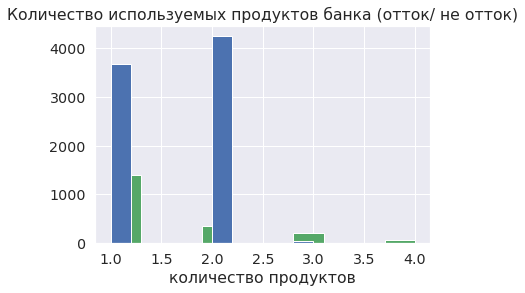

In [ ]:
plt.hist(products_churn, color ='g')
plt.hist(products_no_churn, color='b')
plt.title('Количество используемых продуктов банка (отток/ не отток)')
plt.xlabel('количество продуктов')
plt.show()

Дисперсии выборок разные. Кроме того количестов продуктов - величина дискретная , может принимать целое значение от 1 до 4 в нашем случае. Следовательно критерий Стьюдента не подойдет. Лучше применить критерий Манна-Уитни.
  

In [ ]:
alpha = .05
result_test_m = st.mannwhitneyu(age_churn, age_no_churn)
print('p-значение:', result_test_m.pvalue)
if result_test_m.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.6052007159685838e-230
Отвергаем нулевую гипотезу


In [ ]:
print('Среднее количество используемых банковских продуктов клиентами, ушедшими в отток:', np.mean(products_churn))

Среднее количество используемых банковских продуктов клиентами, ушедшими в отток: 1.4752086401570939


In [ ]:
print('Среднее количество используемых банковских продуктов оставшимися клиентами:', np.mean(products_no_churn))

Среднее количество используемых банковских продуктов оставшимися клиентами: 1.5442672359663443


Исходя из статистического теста делаем вывод, что клиенты, ушедшие в отток и клиенты, которые остались пользуются разным количеством банковских продуктов.

Провели следующие статистические тесты:

* Разницы между доходами клиентов нет
* Разница в возрасте клиентов статистически значима
* Разница в количестве используемых продуктов статистически значима

### Шаг 5. Кластеризация

1. Проведение кластеризации объектов (клиентов)
2. Изучение средних значений признаков для кластеров
3. Изучение распределений признаков для кластеров
4. Анализ доли оттока для каждого кластера

В данном шаге проведем кластеризацию и разделим всех клиентов банка на сравнительно однородные группы, чтобы затем посмотреть какая группа более склонна к оттоку, а какая нет и какие признаки характеры для каждой из группы. Для начала построим дендрограмму и определим количество кластеров. Затем применим алгоритм кластеризации KMeans и разделим наших клиентов на определенное количество кластеров, для каждого из которых посчитаем долю оттока, и сравним их между собой.
    

In [ ]:
df = data.dropna()

Преобразуем категориальные данные с полом и городом в отдельные столбцы с бинарными значениями

In [ ]:
df = pd.get_dummies(df, columns=['city','gender'])

In [ ]:
df.head(1)

,id,score,age,objects,balance,products,credit_card,loyalty,salary,churn,age_group,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
1,15690047,608,41,1,83807.86,1,0,1,112542.58,0,от 35 до 45,0,1,0,1,0


In [ ]:
x = df.drop(['id','churn', 'age_group'], axis = 1)
sc = StandardScaler()
x_sc = sc.fit_transform(x)

In [ ]:
linked = linkage(x_sc, method = 'ward')

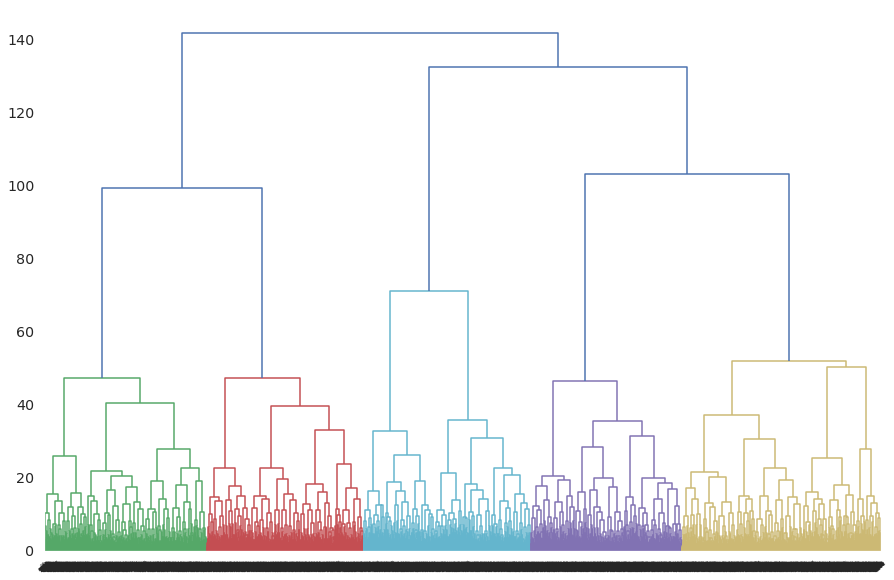

In [ ]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.xticks(rotation=45)
plt.show()

In [ ]:
km = KMeans(random_state=0, n_clusters = 5)

In [ ]:
labels = km.fit_predict(x_sc)

In [ ]:
df['cluster'] = labels

In [ ]:
df.cluster.value_counts()

2    1444
1    1316
3    1278
4    1193
0    1152
Name: cluster, dtype: int64

In [ ]:
df.columns

Index(['id', 'score', 'age', 'objects', 'balance', 'products', 'credit_card',
       'loyalty', 'salary', 'churn', 'age_group', 'city_Ростов Великий',
       'city_Рыбинск', 'city_Ярославль', 'gender_Ж', 'gender_М', 'cluster'],
      dtype='object')

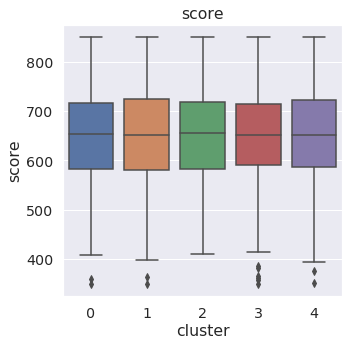

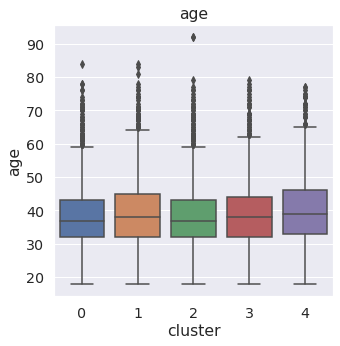

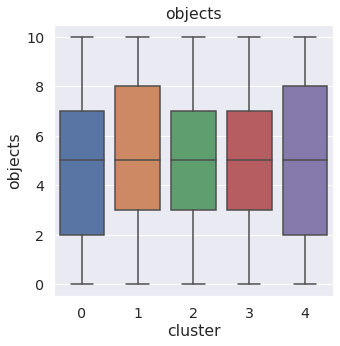

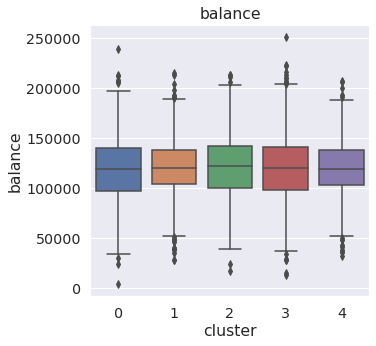

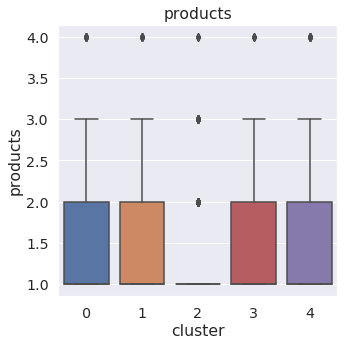

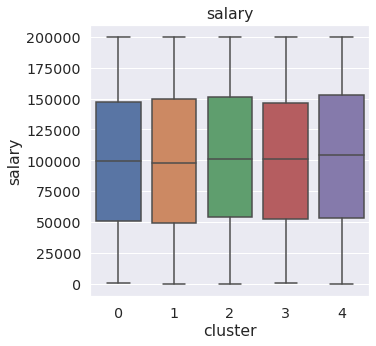

In [ ]:
for column in ['score', 'age', 'objects', 'balance', 'products', 'salary']:
    plt.figure(figsize=(5,5))
    sns.boxplot(x='cluster', y=data[column], data=df)
    plt.title(column)
    plt.show()

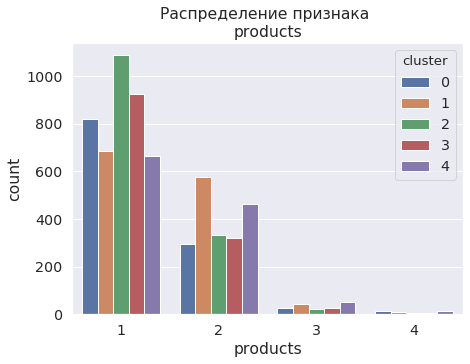

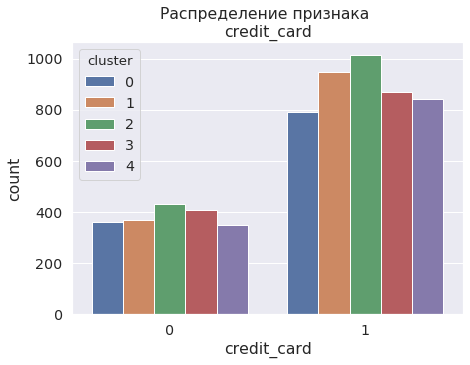

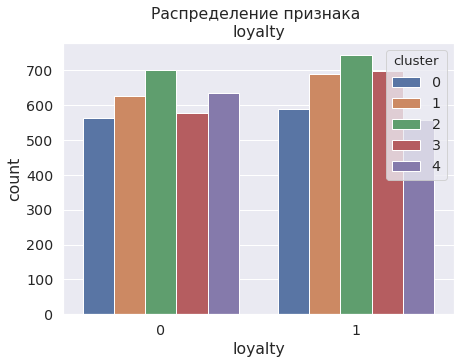

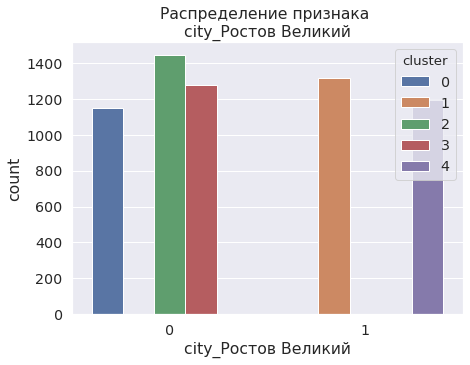

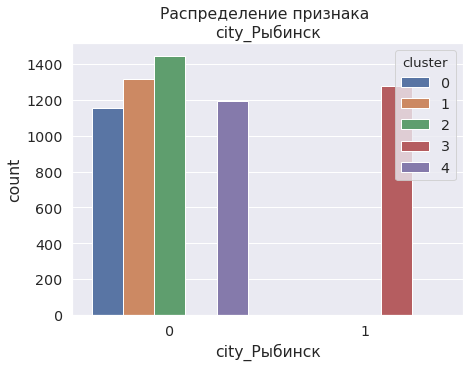

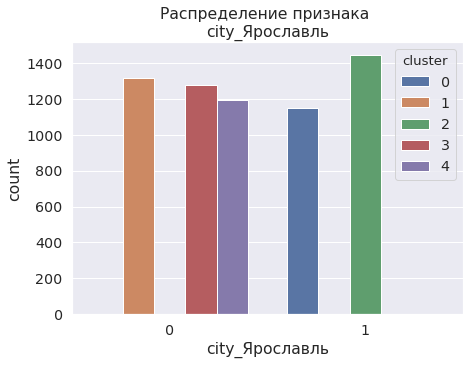

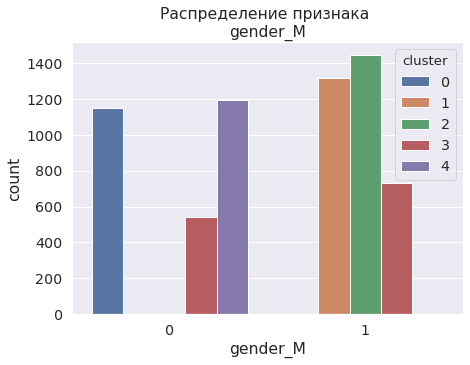

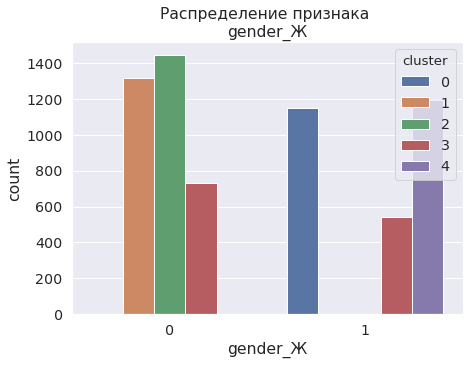

In [ ]:
for column in ['products', 'credit_card', 'loyalty', 'city_Ростов Великий', 'city_Рыбинск', 'city_Ярославль', 'gender_М', 'gender_Ж']:
    plt.figure(figsize=(7,5))
    sns.countplot(data = df, x = column, hue = 'cluster')
    plt.title('Распределение признака \n'+ str(column))

In [ ]:
df.groupby(['cluster']).mean().sort_values('churn')

,id,score,age,objects,balance,products,credit_card,loyalty,salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
cluster,,,,,,,,,,,,,,,
2,1.573184e+07,652.229917,38.546399,5.016620,121151.608213,1.268006,0.701524,0.514543,101302.689751,0.145429,0.0,0.0,1.0,0.000000,1.000000
3,1.573386e+07,651.003912,39.261346,4.982786,119814.985923,1.302817,0.679969,0.546948,100127.281135,0.195618,0.0,1.0,0.0,0.425665,0.574335
0,1.573345e+07,649.233507,38.693576,4.863715,118393.712873,1.335069,0.685764,0.510417,99775.612813,0.228299,0.0,0.0,1.0,1.000000,0.000000
1,1.573521e+07,649.966565,39.424772,5.050152,120259.668222,1.527356,0.720365,0.523556,99905.033959,0.278116,1.0,0.0,0.0,0.000000,1.000000
4,1.573117e+07,653.093881,40.154233,4.965633,119145.966471,1.511316,0.706622,0.468567,102446.424124,0.375524,1.0,0.0,0.0,1.000000,0.000000


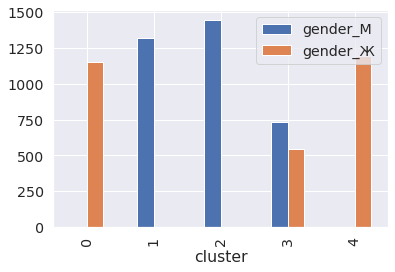

In [ ]:
df.groupby('cluster')[['gender_М', 'gender_Ж']].sum().plot.bar()

In [ ]:
df.groupby('cluster')['churn'].agg('mean').reset_index().sort_values(by='churn', ascending=False)

,cluster,churn
4,4,0.375524
1,1,0.278116
0,0,0.228299
3,3,0.195618
2,2,0.145429


Наименьший отток клиентов в кластере под номером 2 и 3. Больше всего клиентов, которые уходят в отток, принадлежат кластеру 4.
Для клиентов из второго кластера характерно:
* клиенты - мужчины
* пользуются 1 банковским продуктом
* есть кредитная карта
* проживает в Рыбинске

Для клиентов из кластера 4, наиболее склонного к оттоку характерны следующие признаки:
* женщина
* из Ростова Великого
* имеет кредитную карту
* пользуется 1 или 2 продуктами банка

### Шаг 6. Финальный вывод

В данном исследовании проанализировали данные о 10 тысячах клиентах банка "Метанпром". Задачей проекта было анализ признаков для выявления портрета клиентов, склонных к оттоку.

##### Проанализировав данные по 11 признакам сделали следующие выводы:

* Основную часть клиентов банка составляют люди от 18 до 60 лет. Менее 5% составляют клиенты от 60 лет и старше. Максимальный возрастов клиентов - 92 года. Средний возраст клиентов - 38 лет.
* Баллы кредитного скоринга от 350 до 850. Среднее значение - 650 баллов.
* В среднем 5 объектов в собственности (от 0 до 10)
* На счете в среднем 120 тысяч
* Большинство пользуется 1-2 продуктами банка. 3% пользуется 3-4.
* Половина клиентов лояльны
* 70% имеют кредитную карту
* Средняя зарплата 100 тысяч
* 50% клиентов из Ярославля, по 25% из Ростова и Рыбинска.

##### Затем проанализировали клиентов в разрезе двух групп (отток / не отток):

* Половина клиентов из Ростова Великого ушла в отток. Примерно такое количество клиентов (около 800) из Ярославля тоже ушли в отток. Меньшая часть ушедших в отток клиентов из Рыбинска (около 500)
* Почти все клиенты, которые пользуются 3 или 4 продуктами уходят в отток. Из тех, кто пользуется 1 продуктом (примерно 30%) уходят в отток.
* Наибольшая доля тех, кто уходит в отток имеют кредитную карту. Но из не ушедших в отток также большая часть пользуется кредитной картой
* Среди лояльных клиентов меньше доля оттока
* Наибольшая доля оттока среди возрастной категории 45-55 лет и 55-65 лет (почти 50%)

##### Портрет клиента, уходящего в отток

* клиент в возрасте 40-60 лет, наибольшая доля среди женщин
* чаще из Ростова Великого или Ярославля, реже из Рыбинска
* не лоялен к банку
* пользуется 3 и более банковскими продуктами

##### В ходе проведения статистических тестов сделали выводы:

* Разницы между доходами клиентов нет
* Разница в возрасте клиентов статистически значима
* Разница в количестве используемых продуктов статистически значима

##### Затем провели кластеризацию клиентов банка. Было выделено 5 кластеров. Наименьший отток клиентов в кластере под номером 2 и 3. Больше всего клиентов, которые уходят в отток, принадлежат кластеру 4. 

Для клиентов из второго кластера характерно:

* клиенты - мужчины
* пользуются 1 банковским продуктом
* есть кредитная карта
* проживает в Рыбинске

Для клиентов из кластера 4, наиболее склонного к оттоку характерны следующие признаки:

* женщина
* из Ростова Великого
* имеет кредитную карту
* пользуется 1 или 2 продуктами банка

##### Рекоммендации для стратегии взаимодествия с клиентами на основе проведенного анализа:
* сделать упор на клиентов 40+, проведение понятных для клиентов рекламных кампаний и акций, разработка программ для категорий граждан в возрасте
* обратить внимание на обслуживание клиентов в Ростове и Ярославле (так как именно там наибольшая доля оттока)
* разработать программу взаимодействия/ предложений для женщин
* оценить удобство пользования 3 и более услугами банка (выявить причины уходя клиентов с 3 и более продуктами)
* расширить список услуг банка с целью привлечения новых коиентов
* рассмотреть новые условия/ предложения для держателей банковского счета